## AML13 Natural Language Processing with RNNs - Sentiment Analysis

( Chapter 16 – code review)

### Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# If auto-complete (TAB after '.') doesn't work: 
# pip3 install pyreadline

%config IPCompleter.use_jedi = False

## Sentiment Analysis

In [ ]:
tf.random.set_seed(42)

Let's load the IMDB movie dataset:

In [ ]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

/Users/iordan/anaconda3/envs/AML_TF/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/iordan/anaconda3/envs/AML_TF/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### This text is already coded (as number sequences)...

In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [ ]:
# load the "key"
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}

for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
    
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

### ... Let's reloaded it from TFDS where we can recover the text (it's in unicode?)

In [ ]:
### install widgets for code below to work

## (Step1 if you use Jupyter lab) 
##  conda install -n base -c conda-forge jupyterlab_widgets 

# conda install -c conda-forge ipywidgets

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [ ]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [ ]:
train_size, test_size

(25000, 25000)

In [ ]:
for X_batch, y_batch in datasets["train"].batch(4).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:300], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: I gave 1 to this film. I can't understand how Ettore Scola,one of the greater directors of Italian cinema, made a film like this, so stupid and ridiculous! All the stories of the people involved in the movie are unsubstantial,boring and not interesting. Too long,too boring. The only things I save in ...
Label: 0 = Negative

Review: Perhaps being a former Moscovite myself and having an elastic sense of humor prevents me from tossing this movie into the 'arthouse/festival crap' trashcan. It's not the greatest film of 2005, nor is it complete garbage. It just has a lot of problems. I also sincerely doubt this movie was banned due ...
Label: 0 = Negative

Review: ***Might not consider this having a spoiler, but I'd rather be cautious than careless*** I never saw this movie when I was little. I fell in love with it the first time I saw it with my three year old daughter. I can watch it over and over again.<br /><br />For the little acting Ilene Woods did in h ...
Label: 1 = Positive

In [ ]:
### Restrict review size to 300

In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")  ## Numbers are dropped here 
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
preprocess(X_batch, y_batch)
# The "preprocess" is replacing numbers are not coded? See original and preprocessed text
# Review: I gave 1 to this film.
# After preprocess:  [b'I', b'gave', b'to', b'this', b'film', ...]

(<tf.Tensor: id=13799, shape=(4, 58), dtype=string, numpy=
 array([[b'I', b'gave', b'to', b'this', b'film', b'I', b"can't",
         b'understand', b'how', b'Ettore', b'Scola', b'one', b'of',
         b'the', b'greater', b'directors', b'of', b'Italian', b'cinema',
         b'made', b'a', b'film', b'like', b'this', b'so', b'stupid',
         b'and', b'ridiculous', b'All', b'the', b'stories', b'of', b'the',
         b'people', b'involved', b'in', b'the', b'movie', b'are',
         b'unsubstantial', b'boring', b'and', b'not', b'interesting',
         b'Too', b'long', b'too', b'boring', b'The', b'only', b'things',
         b'I', b'save', b'in', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
        [b'Perhaps', b'being', b'a', b'former', b'Moscovite', b'myself',
         b'and', b'having', b'an', b'elastic', b'sense', b'of', b'humor',
         b'prevents', b'me', b'from', b'tossing', b'this', b'movie',
         b'into', b'the', b"'arthouse", b'festival', b"crap'",
         b'trashcan', b"It's", 

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214477), (b'the', 61137), (b'a', 38564)]

In [ ]:
len(vocabulary)

53893

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: id=115500, shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(X_batch[:1,:].shape)
    print(X_batch[:1,-10:])
    print(y_batch)

tf.Tensor(
[[  22    7    1 ...  188  264  503]
 [   6  338 3978 ...    0    0    0]
 [  22   11    2 ...    0    0    0]
 ...
 [1239  132    2 ...    0    0    0]
 [6140 5363 6882 ...    0    0    0]
 [  22   12   38 ...    0    0    0]], shape=(32, 66), dtype=int64)
(1, 66)
tf.Tensor([[  6 184 245   5 238   7   6 188 264 503]], shape=(1, 10), dtype=int64)
tf.Tensor([0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1], shape=(32,), dtype=int64)


In [ ]:
# Sequential model version

embed_size = 128
model_imdb = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model_imdb.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history_imdb = model_imdb.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 323s 413ms/step - loss: 0.5558 - accuracy: 0.7113
Epoch 2/5
781/781 [==============================] - 338s 433ms/step - loss: 0.3893 - accuracy: 0.8345
Epoch 3/5
781/781 [==============================] - 334s 427ms/step - loss: 0.2730 - accuracy: 0.8951
Epoch 4/5
781/781 [==============================] - 385s 493ms/step - loss: 0.1785 - accuracy: 0.9369
Epoch 5/5
781/781 [==============================] - 413s 529ms/step - loss: 0.1211 - accuracy: 0.9585


Or using manual masking:

In [ ]:
## Functional API

K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)

z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)

model_imdb2 = keras.models.Model(inputs=[inputs], outputs=[outputs])
model_imdb2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history_imdb2 = model_imdb2.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 387s 496ms/step - loss: 0.5397 - accuracy: 0.7214
Epoch 2/5
781/781 [==============================] - 657s 841ms/step - loss: 0.3450 - accuracy: 0.8581
Epoch 3/5
781/781 [==============================] - 374s 479ms/step - loss: 0.1911 - accuracy: 0.9309
Epoch 4/5
781/781 [==============================] - 474s 607ms/step - loss: 0.1270 - accuracy: 0.9556
Epoch 5/5
781/781 [==============================] - 384s 491ms/step - loss: 0.0913 - accuracy: 0.9687


In [ ]:
history_imdb2.history, history_imdb2.history

({'loss': [0.5397498152205642,
   0.34500361416159764,
   0.19105957590983214,
   0.12703606837563855,
   0.09132593808750528],
  'accuracy': [0.72139084, 0.8580746, 0.9308579, 0.9555858, 0.96866995]},
 {'loss': [0.5397498152205642,
   0.34500361416159764,
   0.19105957590983214,
   0.12703606837563855,
   0.09132593808750528],
  'accuracy': [0.72139084, 0.8580746, 0.9308579, 0.9555858, 0.96866995]})

In [ ]:
### Measure performnace

Saving figure keras_learning_curves_plot


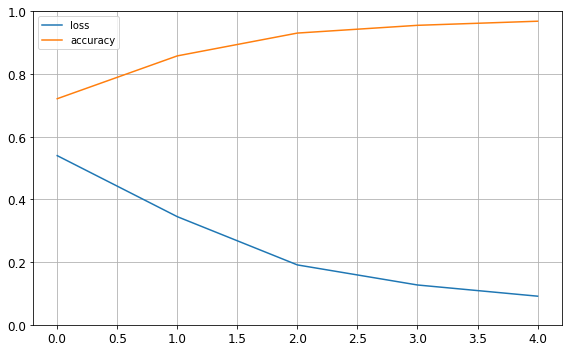

In [ ]:
import pandas as pd

pd.DataFrame(history_imdb2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
history_imdb2.params

{'batch_size': None,
 'epochs': 5,
 'steps': 781,
 'samples': 781,
 'verbose': 1,
 'do_validation': False,
 'metrics': ['loss', 'accuracy']}

### Predict on test data

In [ ]:
### Get a feel of the computations

In [ ]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:300], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that today, or even in 1925, on one side of the world a lady or a baby could have everything served for hi ...
Label: 1 = Positive

Review: Oh yeah! Jenna Jameson did it again! Yeah Baby! This movie rocks. It was one of the 1st movies i saw of her. And i have to say i feel in love with her, she was great in this move.<br /><br />Her performance was outstanding and what i liked the most was the scenery and the wardrobe it was amazing you ...
Label: 1 = Positive



In [ ]:
cnt = 0
for rev,_ in datasets["test"].repeat().batch(1).take(30).map(preprocess):
    if cnt<5:
        print(rev.numpy())
    cnt+=1   

[[b"I've" b'watched' b'the' b'movie' b'actually' b'several' b'times'
  b'And' b'what' b'i' b'want' b'to' b'say' b'about' b'it' b'is' b'the'
  b'only' b'thing' b'that' b'made' b'this' b'movie' b'high' b'rank'
  b'was' b'the' b'Burak' b"Altay's" b'incredible' b'performance'
  b'absolutely' b'nothing' b'but' b'that' b'Not' b'even' b'those'
  b'silly' b'model' b'named' b'Deniz' b'Akkaya' b'and' b'some' b'of'
  b'these' b'popular' b'names' b'at' b'times' b'in' b'the' b'mov']]
[[b'If' b'you' b'love' b'Japanese' b'monster' b'movies' b"you'll" b'love'
  b'this' b'action' b'packed' b'battle' b'pitting' b'an' b'alien'
  b'invader' b'intent' b'upon' b'conquering' b'the' b'Earth' b'and' b'a'
  b'Giant' b'Robot' b'with' b'an' b'armory' b'of' b'super' b'weaponry'
  b'The' b'alien' b'Emporer' b'Guillotine' b'from' b'the' b'planet'
  b'Gargoyle' b'has' b'a' b'army' b'of' b'thugs' b'called' b'of'
  b'course' b'the' b'gargoyl']]
[[b'A' b'film' b'for' b'mature' b'educated' b'audiences' b'I' b'saw'
  b'Ra

In [ ]:
### Prepare the test set

In [ ]:
tst_set = datasets["test"].repeat().batch(32).map(preprocess) # test
tst_set = tst_set.map(encode_words).prefetch(1)

In [ ]:
import time

In [ ]:
t0 = time.time()

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for review_batch, label_batch in tst_set.take(1000):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch.numpy())
    # print(label_batch.numpy())
    # compute predictions
    preds = model_imdb2.predict(review_batch)
    ## append predicted labels
    #y_pred.append(np.argmax(preds, axis = - 1))
    y_pred.append(preds)

# convert the true and predicted labels into tensors
# correct_labels = tf.concat([item for item in y_true], axis = 0)
# predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(time.time()-t0)
# In seconds (~4mins)

215.7462911605835


In [ ]:
# correct_labels

In [ ]:
len(y_pred), len(y_true)

(1000, 1000)

In [ ]:
#old: 
# y_proba = model_imdb2.predict(tst_set)
# pred = y_proba.flatten()
y_true = np.array(y_true).flatten()
pred = np.array(y_pred).flatten()

<AxesSubplot:>

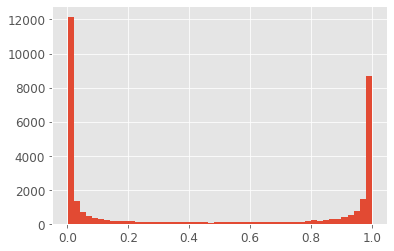

In [ ]:
pd.Series(pred).hist(bins=50)

In [ ]:
# [v for v in tst_set.as_numpy_iterator()][:4]

In [ ]:
### The labels read directly from the test dataset are "shuffled"
# Compare the predicted ptobabilites to them and to the labels pulled by looping through batches

In [ ]:
pred[:10]

array([0.99607515, 0.9960827 , 0.9761307 , 0.9025312 , 0.6016566 ,
       0.9994259 , 0.0029861 , 0.9973085 , 0.9997983 , 0.00215691],
      dtype=float32)

In [ ]:
y_test[:10], y_true[:10] #correct_labels[:10]

(array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1]), array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0]))

In [ ]:
### Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [ ]:
# Confusion matrix

def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Positive (Actual): ', np.sum(cm[1]))
    
    print('Accuracy @{:.2f}:'.format(p), '{:.3f}'.format((cm[0][0]+cm[1][1])/len(labels)))

In [ ]:
# ROC
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']
    
def plot_roc(name, labels, predictions, **kwargs):
    
    #plt.figure(figsize = (6, 6))
    plt.style.use('ggplot')
    
    fp, tp, _ = roc_curve(labels, predictions)

    lbl = name + " AUC: "+str(round(roc_auc_score(1-labels, 1-predictions.ravel()),3))
    plt.plot(100*fp, 100*tp, label=lbl, linewidth=2, **kwargs)
    plt.plot(100*fp, 100*fp,'r--');
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    #plt.grid(True)
    
    #plt.plot(fpr, tpr, label = "ROC score: "+str(round(roc_auc_score(1-y_test, 1-pred_vals[:,1]),3)), color = "violet", lw = 3);

    ax = plt.gca()
    ax.set_aspect('equal')

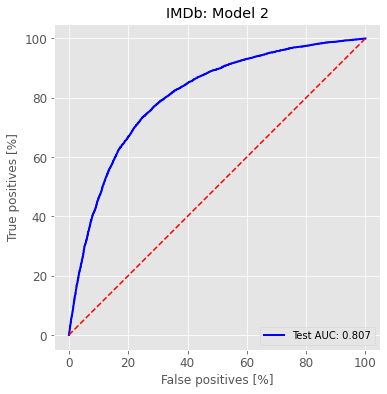

In [ ]:
plt.figure(figsize = (6, 6))

plt.title('IMDb: Model 2')
# plot_roc("Test", y_test, pred, color=colors[2]) #, linestyle='--')
plot_roc("Test", y_true, pred, color=colors[2]) #, linestyle='--')

plt.legend(loc='lower right')

True Negatives:  12598
False Positives:  3471
False Negatives:  4903
True Positives:  11028
Total Positive (Actual):  15931
Accuracy @0.50: 0.738


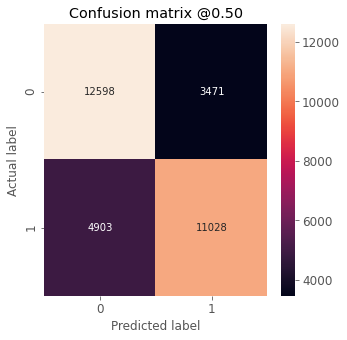

In [ ]:
plot_cm(y_true,pred)

In [ ]:
### Question: What is the reason for the bad performance on test data?

# Possible answers:

# 1) The order of (observations with) the predicted probabilities somehow doesn't match the order (observations with) of the binary labels
#
#    Yes, that was fixed using loops on the batched data

# 2a) Model overfits on train data (there is no validation data) and thus fails on test data
# 2b) Model needs to train longer - only 5 epochs are not enough -> Train in COLAB (then maybe download locally asin AML8_NLP_RNN.ipynb)

# 3) Vocabulary is built on train data - may be test data has very different set if words (and they get coded in the "overflow" buckets - oov)

### Need to check this ==>

#### Reusing Pretrained Embeddings

In [ ]:
tf.random.set_seed(42)

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [ ]:
# !conda install -c anaconda tensorflow-hub -y

In [ ]:
import tensorflow_hub as hub

In [ ]:
model_imdb3 = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model_imdb3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history_imdb3 = model_imdb3.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 33s 42ms/step - loss: 0.5492 - accuracy: 0.7234
Epoch 2/5
781/781 [==============================] - 36s 46ms/step - loss: 0.5137 - accuracy: 0.7496
Epoch 3/5
781/781 [==============================] - 35s 45ms/step - loss: 0.5079 - accuracy: 0.7537
Epoch 4/5
781/781 [==============================] - 31s 40ms/step - loss: 0.5055 - accuracy: 0.7540
Epoch 5/5
781/781 [==============================] - 33s 42ms/step - loss: 0.5010 - accuracy: 0.7570
